# Temporal Mask Stabilization for Video Segmentation (трек А)

**Цель работы.**

В данной работе рассматривается задача временной стабилизации бинарных масок объектов на видеопоследовательности. На практике сегментационные модели, применяемые покадрово, демонстрируют сильную временную нестабильность: маски «дрожат», скачкообразно меняют площадь и могут кратковременно пропадать. Это особенно заметно в сложных условиях съёмки (ночное видео, блики, движение камеры и объектов).

Целью является уменьшение временной нестабильности масок без переобучения модели сегментации, используя только постобработку на уровне видеопоследовательности.

---

**Выбор модели сегментации.**
В качестве базовой модели сегментации выбрана **Mask R-CNN** с предобученными весами COCO из `torchvision`.

Данный выбор обусловлен следующими причинами:

* модель выполняет **instance segmentation**, что позволяет отслеживать отдельные объекты, а не только класс целиком;
* доступна стабильная реализация с предобученными весами без необходимости загрузки внешних репозиториев;
* модель возвращает не только маску, но и **оценку уверенности**, что важно для логики подавления ложных масок;
* Mask R-CNN является распространённым и хорошо интерпретируемым baseline, что делает эксперимент воспроизводимым.

Хотя более современные модели (например, Mask2Former или YOLO-Seg) потенциально лучше подходят для ночных дорожных сцен, их использование усложнило бы воспроизводимость и не являлось необходимым для демонстрации методов временного сглаживания.

---

**Инженерное описание решения.**

Для временной стабилизации масок использован метод, сочетающий:

* перенос маски по оптическому потоку;
* взвешенное объединение с текущим предсказанием модели;
* экспоненциальное сглаживание по времени.

Ключевые чувствительные параметры:

* `ema_beta` — определяет инерционность маски (слишком большое значение приводит к залипанию);
* `flow_alpha` и `motion_sigma` — баланс доверия к оптическому потоку;
* `bin_thr` и параметры адаптивного порога — влияют на стабильность площади;
* параметры авто-исчезновения (`EWMA confidence`, `miss_streak`) — определяют момент завершения трека.

Сглаживание наиболее эффективно уменьшает дрожание маски и скачки площади, однако может ухудшать локальную точность сегментации в условиях низкой уверенности модели. Поэтому в решение включена логика автоматического подавления маски при отсутствии подтверждения объекта.


# Решение

## 1 — импорты и путь к видео

In [1]:
import os
import sys
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product

try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **kw: x

VIDEO_PATH = "/tf/konokhova/va/hw2/video.mp4"
assert Path(VIDEO_PATH).exists(), f"Видео не найдено: {VIDEO_PATH}"

print("python:", sys.version)
print("opencv:", cv2.__version__)
print("cwd:", os.getcwd())
print("video:", VIDEO_PATH)

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


python: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
opencv: 4.11.0
cwd: /tf/konokhova/va/hw2
video: /tf/konokhova/va/hw2/video.mp4


## 2 — чтение видеоинформации и первого кадра

In [2]:
def read_video_info(video_path: str):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), f"Не удалось открыть видео: {video_path}"
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = float(cap.get(cv2.CAP_PROP_FPS) or 25.0)
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

    ret, frame0 = cap.read()
    cap.release()
    assert ret and frame0 is not None, "Не удалось прочитать первый кадр"

    return w, h, fps, n, frame0

W, H, FPS, N_FRAMES, frame0 = read_video_info(VIDEO_PATH)
print({"w": W, "h": H, "fps": FPS, "frames": N_FRAMES})
frame0.shape, frame0.dtype

{'w': 1920, 'h': 1080, 'fps': 25.0, 'frames': 426}


((1080, 1920, 3), dtype('uint8'))

## 3 — загрузка Mask R-CNN

In [3]:
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
preprocess = weights.transforms()

model = maskrcnn_resnet50_fpn_v2(weights=weights).eval().to(DEVICE)

device: cuda


## 4 — утилиты: IoU, CV, постпроцесс, overlay

In [4]:
def iou_binary(a: np.ndarray, b: np.ndarray) -> float:
    a = a.astype(bool)
    b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return float(inter / union) if union > 0 else 1.0

def cv_ratio(xs):
    xs = np.asarray(xs, dtype=np.float32)
    m = float(xs.mean()) if xs.size else 0.0
    s = float(xs.std()) if xs.size else 0.0
    return float(s / m) if m > 1e-6 else 0.0

def postprocess_binary(prob: np.ndarray, thr=0.5, morph_kernel=5, keep_largest=True) -> np.ndarray:
    mask = (prob >= float(thr)).astype(np.uint8)

    if morph_kernel and morph_kernel > 1:
        k = int(morph_kernel)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    if keep_largest:
        num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        if num > 1:
            areas = stats[1:, cv2.CC_STAT_AREA]
            largest_idx = 1 + int(np.argmax(areas))
            mask = (labels == largest_idx).astype(np.uint8)

    return mask

def overlay_mask_on_frame(frame_bgr: np.ndarray, mask_bin: np.ndarray, alpha: float = 0.45) -> np.ndarray:
    overlay = frame_bgr.copy()
    overlay[mask_bin.astype(bool)] = (0, 255, 0)
    return cv2.addWeighted(frame_bgr, 1.0 - alpha, overlay, alpha, 0.0)


## 5 — предсказание маски и «уверенность» кадра

In [5]:
def frame_to_prob_mask_and_conf(frame_bgr: np.ndarray, score_thresh: float = 0.6, max_dets: int = 15):
    """
    Возвращает:
      prob_mask: (H,W) float32 [0,1] или None
      conf_score: float (0..1) — грубая уверенность (среднее top 1% пикселей)
    """
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(rgb).permute(2, 0, 1)
    img = preprocess(img).to(DEVICE)

    with torch.no_grad():
        out = model([img])[0]

    scores = out["scores"].detach().cpu().numpy()
    if scores.size == 0:
        return None, 0.0

    keep = scores >= score_thresh
    if not np.any(keep):
        return None, 0.0

    idx = np.where(keep)[0][:max_dets]
    masks = out["masks"][idx, 0].detach().cpu().numpy().astype(np.float32)
    scores_kept = scores[idx]
    best = int(np.argmax(scores_kept))
    prob = masks[best]

    flat = prob.reshape(-1)
    k = int(flat.size * 0.99)
    top = np.partition(flat, k)[k:] if flat.size > 0 else flat
    conf = float(top.mean()) if top.size else float(prob.max())

    return prob, conf

prob0, conf0 = frame_to_prob_mask_and_conf(frame0, score_thresh=0.6)
print("prob0:", None if prob0 is None else (prob0.shape, float(prob0.min()), float(prob0.max())))
print("conf0:", conf0)


prob0: ((1080, 1920), 0.0, 0.9978166818618774)
conf0: 0.09535431861877441


## 6 — Flow, warp, EMA, motion-weighted fusion

**Идея временного сглаживания.**
Стабилизация масок выполняется за счёт использования информации из предыдущих кадров. Основная идея состоит в том, чтобы:

1. перенести предыдущую маску в текущий кадр с помощью оптического потока;
2. объединить перенесённую маску с текущим предсказанием модели;
3. сгладить результат по времени.

Таким образом, маска на текущем кадре формируется не только на основе одиночного предсказания модели, но и с учётом временного контекста.

In [6]:
def flow_farneback(prev_bgr, next_bgr, downscale=0.5):
    prev_gray = cv2.cvtColor(prev_bgr, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_bgr, cv2.COLOR_BGR2GRAY)

    if downscale < 1.0:
        new_size = (int(prev_gray.shape[1]*downscale), int(prev_gray.shape[0]*downscale))
        p = cv2.resize(prev_gray, new_size, interpolation=cv2.INTER_AREA)
        n = cv2.resize(next_gray, new_size, interpolation=cv2.INTER_AREA)
        flow_s = cv2.calcOpticalFlowFarneback(p, n, None, 0.5, 3, 21, 3, 5, 1.2, 0)
        flow = cv2.resize(flow_s, (prev_gray.shape[1], prev_gray.shape[0]), interpolation=cv2.INTER_LINEAR)
        flow[..., 0] /= downscale
        flow[..., 1] /= downscale
        return flow.astype(np.float32)

    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 21, 3, 5, 1.2, 0)
    return flow.astype(np.float32)

def warp_prob(prob_prev, flow):
    hh, ww = prob_prev.shape
    gx, gy = np.meshgrid(np.arange(ww, dtype=np.float32), np.arange(hh, dtype=np.float32))
    mapx = gx - flow[..., 0]
    mapy = gy - flow[..., 1]
    out = cv2.remap(prob_prev.astype(np.float32), mapx, mapy, cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_CONSTANT, borderValue=0.0)
    return np.clip(out, 0.0, 1.0).astype(np.float32)

def ema(prev_s, cur, beta=0.85):
    return np.clip(beta * prev_s + (1.0 - beta) * cur, 0.0, 1.0).astype(np.float32)

def fuse_improved(prob_model, conf_model, prob_warp, flow, alpha=0.65, motion_sigma=7.0, conf_thr=0.35):
    """
    Смешивание warp и модели.
    Чем больше движение, тем меньше доверяем warp.
    Если conf модели низкий, уменьшаем её вклад.
    """
    if prob_model is None:
        return prob_warp

    mag = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
    w_motion = np.exp(-mag / max(motion_sigma, 1e-6)).astype(np.float32)

    g_conf = 0.0 if conf_model < conf_thr else 1.0

    w = (alpha * w_motion).astype(np.float32)
    w = np.clip(w + (1.0 - w) * (1.0 - g_conf), 0.0, 1.0).astype(np.float32)

    fused = w * prob_warp + (1.0 - w) * prob_model
    return np.clip(fused, 0.0, 1.0).astype(np.float32)


## 7 — Params, objective weights, adaptive threshold

In [7]:
@dataclass(frozen=True)
class Params:
    bin_thr: float
    ema_beta: float
    flow_alpha: float
    motion_sigma: float
    morph_kernel: int
    conf_thr: float

# веса целевой функции для autotune
LAMBDA_IOU  = 1.0
LAMBDA_L1   = 0.5
LAMBDA_AREA = 0.3

def adaptive_binarize_by_area(prob: np.ndarray, thr: float, target_area: float,
                              tol_up=0.55, tol_down=0.55,
                              morph_kernel=3, keep_largest=True, max_iters=5):
    lo = max(0.05, thr - 0.25)
    hi = min(0.95, thr + 0.25)

    best_mask = postprocess_binary(prob, thr=thr, morph_kernel=morph_kernel, keep_largest=keep_largest)
    best_area = float(best_mask.sum())

    min_area = target_area * (1.0 - tol_down)
    max_area = target_area * (1.0 + tol_up)

    if min_area <= best_area <= max_area:
        return best_mask, thr

    cur_thr = thr
    for _ in range(max_iters):
        cur_thr = 0.5 * (lo + hi)
        mask = postprocess_binary(prob, thr=cur_thr, morph_kernel=morph_kernel, keep_largest=keep_largest)
        area = float(mask.sum())
        best_mask, best_area = mask, area

        if area > max_area:
            lo = cur_thr
        elif area < min_area:
            hi = cur_thr
        else:
            return mask, cur_thr

    return best_mask, cur_thr


## 8 — Area clamp (снижает area_cv)

In [8]:
# Ограничиваем изменение площади за кадр
AREA_UP_RATIO = 1.25
AREA_DOWN_RATIO = 0.75

def clamp_mask_area_by_morph(mask: np.ndarray, target_area: float, k0: int, max_iters: int = 4):
    cur = float(mask.sum())
    if target_area <= 1.0 or cur <= 1.0:
        return mask

    if abs(cur - target_area) / target_area < 0.08:
        return mask

    out = mask.copy().astype(np.uint8)
    k = max(3, int(k0) | 1)  # нечётный
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

    for _ in range(max_iters):
        cur = float(out.sum())
        if cur > target_area:
            out = cv2.erode(out, kernel, iterations=1)
        else:
            out = cv2.dilate(out, kernel, iterations=1)

        if out.sum() == 0:
            break

        cur2 = float(out.sum())
        if abs(cur2 - target_area) / max(target_area, 1.0) < 0.08:
            break

    return out


## 9 — Auto vanish (EWMA confidence + miss streak + fade)

**Подавление артефактов стабилизации.**
При сильном временном сглаживании возможно появление артефактов, когда маска продолжает существовать даже после того, как объект покинул кадр. Для устранения этого эффекта введена дополнительная логика авто-исчезновения объекта.

Решение основывается на следующих признаках:

* экспоненциально сглаженной уверенности модели (EWMA confidence);
* отсутствии подтверждения объекта на текущем кадре (низкая IoU между raw и стабилизированной маской);
* малой площади сырой маски.

При длительном отсутствии подтверждения маска плавно подавляется (fade-out), что предотвращает появление «маски-призрака».

Дополнительно вводится контроль изменения площади маски между кадрами, ограничивающий резкие скачки площади и уменьшающий дисперсию этой величины во времени.

In [9]:
# Параметры авто-исчезновения
CONF_EWMA_BETA = 0.85
CONF_EWMA_VANISH = 0.10
RAW_AREA_VANISH_FRAC = 0.002
IOU_VANISH = 0.12
MISS_STREAK_TO_FADE = 4
FADE_STEPS = 8

@dataclass
class TrackState:
    conf_ewma: float = 0.0
    miss_streak: int = 0
    fading: bool = False
    fade_left: int = 0

def apply_auto_vanish_and_area_control(
    stab_prob: np.ndarray,
    stab_bin: np.ndarray,
    raw_bin: np.ndarray,
    conf_raw: float,
    prev_area: float,
    bin_thr: float,
    morph_kernel: int,
    state: TrackState,
):
    # EWMA confidence
    state.conf_ewma = CONF_EWMA_BETA * state.conf_ewma + (1.0 - CONF_EWMA_BETA) * float(conf_raw)

    raw_area = float(raw_bin.sum())
    hw_area = float(H * W)
    raw_area_small = raw_area < (RAW_AREA_VANISH_FRAC * hw_area)

    if raw_bin.sum() > 0 and stab_bin.sum() > 0:
        iou_raw_stab = iou_binary(raw_bin, stab_bin)
    else:
        iou_raw_stab = 0.0

    no_confirmation = (state.conf_ewma < CONF_EWMA_VANISH) or (raw_area_small and iou_raw_stab < IOU_VANISH)

    # miss streak / reset
    if no_confirmation:
        state.miss_streak += 1
    else:
        state.miss_streak = 0
        if state.fading:
            state.fading = False
            state.fade_left = 0

    # enter fading
    if (not state.fading) and (state.miss_streak >= MISS_STREAK_TO_FADE):
        state.fading = True
        state.fade_left = FADE_STEPS

    # fading behaviour
    if state.fading:
        step = max(state.fade_left, 1)
        decay = (step - 1) / step
        stab_prob = (stab_prob * decay).astype(np.float32)
        stab_bin = postprocess_binary(stab_prob, thr=bin_thr, morph_kernel=morph_kernel, keep_largest=True)

        state.fade_left -= 1
        if state.fade_left <= 0 or stab_bin.sum() == 0:
            stab_prob[:] = 0.0
            stab_bin[:] = 0
            state.fading = False
            state.fade_left = 0
            state.miss_streak = 0

        return stab_prob, stab_bin, state

    # area clamp (reduce spikes)
    cur_area = float(stab_bin.sum())
    prev_area = float(max(prev_area, 1.0))
    max_area = prev_area * AREA_UP_RATIO
    min_area = prev_area * AREA_DOWN_RATIO

    if cur_area > max_area:
        stab_bin = clamp_mask_area_by_morph(stab_bin, target_area=max_area, k0=morph_kernel, max_iters=4)
    elif 0 < cur_area < min_area:
        stab_bin = clamp_mask_area_by_morph(stab_bin, target_area=min_area, k0=morph_kernel, max_iters=4)

    return stab_prob, stab_bin, state


## 10 — Caches (model + flow)

In [10]:
def precompute_model_cache(video_path: str, N: int, score_thresh: float = 0.6, save_frames: bool = False):
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened()

    frames = []
    probs = []
    confs = []

    ret, frame = cap.read()
    idx = 0
    while ret and idx < N:
        prob, conf = frame_to_prob_mask_and_conf(frame, score_thresh=score_thresh)
        if prob is None:
            prob = np.zeros((H, W), dtype=np.float32)
            conf = 0.0

        if save_frames:
            frames.append(frame)
        probs.append(prob.astype(np.float32))
        confs.append(float(conf))

        ret, frame = cap.read()
        idx += 1

    cap.release()

    probs = np.stack(probs, axis=0)
    confs = np.asarray(confs, dtype=np.float32)

    return (frames if save_frames else None), probs, confs

def precompute_flow_cache(frames: list, downscale: float = 0.5):
    flows = []
    for i in range(len(frames) - 1):
        flows.append(flow_farneback(frames[i], frames[i+1], downscale=downscale))
    return flows

N_CACHE = 120
frames_cache, prob_cache, conf_cache = precompute_model_cache(
    VIDEO_PATH, N=N_CACHE, score_thresh=0.6, save_frames=True
)
flow_cache = precompute_flow_cache(frames_cache, downscale=0.5)

print("cached:", len(frames_cache), prob_cache.shape, conf_cache.shape)
print("flows:", len(flow_cache), flow_cache[0].shape)


cached: 120 (120, 1080, 1920) (120,)
flows: 119 (1080, 1920, 2)


## 11 — Evaluate cached (для autotune)

In [11]:
def evaluate_params_cached(prob_cache: np.ndarray, conf_cache: np.ndarray, flow_cache: list, params: Params):
    T = prob_cache.shape[0]
    stab_prob = prob_cache[0].copy()
    stab_bin = postprocess_binary(stab_prob, thr=params.bin_thr, morph_kernel=params.morph_kernel)

    ious, l1s, areas = [], [], [float(stab_bin.sum())]
    thr_used = [params.bin_thr]

    for t in range(1, T):
        prob_model = prob_cache[t]
        conf_model = float(conf_cache[t])
        flow = flow_cache[t-1]

        warped = warp_prob(stab_prob, flow)
        fused = fuse_improved(
            prob_model=prob_model,
            conf_model=conf_model,
            prob_warp=warped,
            flow=flow,
            alpha=params.flow_alpha,
            motion_sigma=params.motion_sigma,
            conf_thr=params.conf_thr,
        )
        stab_prob_next = ema(stab_prob, fused, beta=params.ema_beta)

        target_area = max(areas[-1], 1.0)
        stab_bin_next, thr_adj = adaptive_binarize_by_area(
            stab_prob_next,
            thr=params.bin_thr,
            target_area=target_area,
            tol_up=0.55,
            tol_down=0.55,
            morph_kernel=params.morph_kernel,
            keep_largest=True,
            max_iters=5,
        )
        thr_used.append(float(thr_adj))

        ious.append(iou_binary(stab_bin, stab_bin_next))
        l1s.append(float(np.mean(np.abs(stab_prob - stab_prob_next))))
        areas.append(float(stab_bin_next.sum()))

        stab_prob, stab_bin = stab_prob_next, stab_bin_next

    mean_iou = float(np.mean(ious)) if ious else 0.0
    mean_l1  = float(np.mean(l1s)) if l1s else 0.0
    area_cv  = float(cv_ratio(areas))
    thr_std  = float(np.std(thr_used)) if len(thr_used) else 0.0

    loss = (
        LAMBDA_IOU  * (1.0 - mean_iou) +
        LAMBDA_L1   * mean_l1 +
        LAMBDA_AREA * area_cv
    )

    return {
        "loss": loss,
        "mean_iou": mean_iou,
        "mean_l1": mean_l1,
        "area_cv": area_cv,
        "thr_std": thr_std,
        "frames_used": int(T),
        **params.__dict__,
    }


## 12 — Autotune (random search)

In [12]:
def sample_param():
    return Params(
        bin_thr=float(np.random.choice([0.5, 0.6, 0.65])),
        ema_beta=float(np.random.choice([0.80, 0.85, 0.90])),
        flow_alpha=float(np.random.choice([0.45, 0.55, 0.65])),
        motion_sigma=float(np.random.choice([5.0, 7.0])),
        morph_kernel=int(np.random.choice([3, 5])),
        conf_thr=float(np.random.choice([0.30, 0.35, 0.40])),
    )

N_SAMPLES = 120
rows = []
for _ in tqdm(range(N_SAMPLES)):
    p = sample_param()
    rows.append(evaluate_params_cached(prob_cache, conf_cache, flow_cache, p))

df_fast = pd.DataFrame(rows).sort_values("loss").reset_index(drop=True)

print("BEST:")
display(df_fast.head(1))
print("TOP-10:")
display(df_fast.head(10))

best_row = df_fast.iloc[0].to_dict()
best_params = Params(
    bin_thr=float(best_row["bin_thr"]),
    ema_beta=float(best_row["ema_beta"]),
    flow_alpha=float(best_row["flow_alpha"]),
    motion_sigma=float(best_row["motion_sigma"]),
    morph_kernel=int(best_row["morph_kernel"]),
    conf_thr=float(best_row["conf_thr"]),
)
best_params


100%|██████████████████████████████████████████████████████████████████████████████████| 120/120 [13:55<00:00,  6.96s/it]

BEST:


,loss,mean_iou,mean_l1,area_cv,thr_std,frames_used,bin_thr,ema_beta,flow_alpha,motion_sigma,morph_kernel,conf_thr
0,0.297645,0.884405,0.001686,0.604022,0.048872,120,0.5,0.85,0.45,5.0,3,0.35


TOP-10:


,loss,mean_iou,mean_l1,area_cv,thr_std,frames_used,bin_thr,ema_beta,flow_alpha,motion_sigma,morph_kernel,conf_thr
0,0.297645,0.884405,0.001686,0.604022,0.048872,120,0.5,0.85,0.45,5.0,3,0.35
1,0.297645,0.884405,0.001686,0.604022,0.048872,120,0.5,0.85,0.45,5.0,3,0.40
2,0.311161,0.881250,0.001491,0.638885,0.040991,120,0.5,0.85,0.65,7.0,3,0.40
3,0.311334,0.881097,0.001491,0.638954,0.040991,120,0.5,0.85,0.65,7.0,5,0.40
4,0.345843,0.880030,0.001944,0.749669,0.039947,120,0.5,0.80,0.55,7.0,3,0.30
5,0.345979,0.879973,0.001944,0.749934,0.039947,120,0.5,0.80,0.55,7.0,5,0.35
6,0.347199,0.853608,0.001633,0.666633,0.056141,120,0.6,0.85,0.45,7.0,3,0.35
7,0.347199,0.853608,0.001633,0.666633,0.056141,120,0.6,0.85,0.45,7.0,3,0.35
8,0.347489,0.853312,0.001633,0.666616,0.056141,120,0.6,0.85,0.45,7.0,5,0.30
9,0.352074,0.866488,0.001565,0.725931,0.045357,120,0.5,0.85,0.55,7.0,3,0.30


Params(bin_thr=0.5, ema_beta=0.85, flow_alpha=0.45, motion_sigma=5.0, morph_kernel=3, conf_thr=0.35)

## 13 — запуск полного прогона и просмотр результатов

**Экспериментальная постановка.**
Сравнение проводится между:

* **raw** — масками, полученными напрямую от модели сегментации;
* **stabilized** — масками после применения предложенного алгоритма временной стабилизации.

Оценка качества проводится по следующим метрикам:

* **Mean IoU** между масками на соседних кадрах (характеризует временную согласованность);
* **Mean L1** между вероятностными картами (характеризует плавность изменений);
* **Coefficient of Variation (CV)** площади маски (характеризует стабильность размера объекта).

Также анализируются временные графики изменения IoU, площади маски, адаптивного порога и уверенности модели.

In [13]:
def run_full_video_with_area_and_auto_vanish(
    video_path: str,
    out_dir: Path,
    params: Params,
    score_thresh: float = 0.6,
    downscale: float = 0.5,
):
    out_dir.mkdir(exist_ok=True, parents=True)

    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), f"Не удалось открыть видео: {video_path}"

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = float(cap.get(cv2.CAP_PROP_FPS) or 25.0)

    preview_path = out_dir / "preview_raw_vs_stabilized.mp4"
    writer = cv2.VideoWriter(str(preview_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w * 2, h))

    raw_iou, raw_l1, raw_area = [], [], []
    stab_iou, stab_l1, stab_area = [], [], []
    thr_series = []
    conf_series = []
    miss_series = []

    # first frame
    ret, prev_frame = cap.read()
    assert ret

    prob_raw_prev, conf_raw_prev = frame_to_prob_mask_and_conf(prev_frame, score_thresh=score_thresh)
    if prob_raw_prev is None:
        prob_raw_prev = np.zeros((h, w), dtype=np.float32)
        conf_raw_prev = 0.0

    raw_bin_prev = postprocess_binary(prob_raw_prev, thr=params.bin_thr, morph_kernel=params.morph_kernel)
    stab_prob_prev = prob_raw_prev.copy()
    stab_bin_prev = postprocess_binary(stab_prob_prev, thr=params.bin_thr, morph_kernel=params.morph_kernel)

    state = TrackState(conf_ewma=float(conf_raw_prev))

    thr_series.append(params.bin_thr)
    conf_series.append(float(state.conf_ewma))
    miss_series.append(int(state.miss_streak))

    raw_area.append(float(raw_bin_prev.sum()))
    stab_area.append(float(stab_bin_prev.sum()))

    writer.write(np.concatenate([
        overlay_mask_on_frame(prev_frame, raw_bin_prev),
        overlay_mask_on_frame(prev_frame, stab_bin_prev)
    ], axis=1))

    idx = 1
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # RAW
        prob_raw, conf_raw = frame_to_prob_mask_and_conf(frame, score_thresh=score_thresh)
        if prob_raw is None:
            prob_raw_vis = np.zeros((h, w), dtype=np.float32)
            conf_raw = 0.0
            raw_bin = np.zeros((h, w), dtype=np.uint8)
        else:
            prob_raw_vis = prob_raw
            raw_bin = postprocess_binary(prob_raw_vis, thr=params.bin_thr, morph_kernel=params.morph_kernel)

        # Stabilize candidate
        flow = flow_farneback(prev_frame, frame, downscale=downscale)
        warped = warp_prob(stab_prob_prev, flow)

        fused = fuse_improved(
            prob_model=prob_raw,
            conf_model=conf_raw,
            prob_warp=warped,
            flow=flow,
            alpha=params.flow_alpha,
            motion_sigma=params.motion_sigma,
            conf_thr=params.conf_thr,
        )
        stab_prob_candidate = ema(stab_prob_prev, fused, beta=params.ema_beta)

        # soft adaptive threshold (area corridor)
        target_area = max(stab_area[-1], 1.0)
        stab_bin_candidate, thr_adj = adaptive_binarize_by_area(
            stab_prob_candidate,
            thr=params.bin_thr,
            target_area=target_area,
            tol_up=0.55,
            tol_down=0.55,
            morph_kernel=params.morph_kernel,
            keep_largest=True,
            max_iters=5,
        )

        # auto vanish + area clamp
        prev_stab_area = float(stab_area[-1]) if len(stab_area) else float(stab_bin_prev.sum())
        stab_prob, stab_bin, state = apply_auto_vanish_and_area_control(
            stab_prob_candidate,
            stab_bin_candidate,
            raw_bin,
            conf_raw,
            prev_area=prev_stab_area,
            bin_thr=params.bin_thr,
            morph_kernel=params.morph_kernel,
            state=state,
        )

        # logs
        thr_series.append(float(thr_adj))
        conf_series.append(float(state.conf_ewma))
        miss_series.append(int(state.miss_streak))

        # metrics
        raw_iou.append(iou_binary(raw_bin_prev, raw_bin))
        stab_iou.append(iou_binary(stab_bin_prev, stab_bin))

        raw_l1.append(float(np.mean(np.abs(prob_raw_prev - prob_raw_vis))))
        stab_l1.append(float(np.mean(np.abs(stab_prob_prev - stab_prob))))

        raw_area.append(float(raw_bin.sum()))
        stab_area.append(float(stab_bin.sum()))

        # write preview
        writer.write(np.concatenate([
            overlay_mask_on_frame(frame, raw_bin),
            overlay_mask_on_frame(frame, stab_bin)
        ], axis=1))

        # update states
        prev_frame = frame
        prob_raw_prev = prob_raw_vis
        raw_bin_prev = raw_bin
        stab_prob_prev = stab_prob
        stab_bin_prev = stab_bin
        idx += 1

    cap.release()
    writer.release()

    summary = {
        "frames_processed": int(idx),
        "preview_video": str(preview_path),
        "params": params.__dict__,
        "raw": {
            "mean_iou": float(np.mean(raw_iou)) if raw_iou else 0.0,
            "mean_l1": float(np.mean(raw_l1)) if raw_l1 else 0.0,
            "area_cv": float(cv_ratio(raw_area)),
        },
        "stabilized": {
            "mean_iou": float(np.mean(stab_iou)) if stab_iou else 0.0,
            "mean_l1": float(np.mean(stab_l1)) if stab_l1 else 0.0,
            "area_cv": float(cv_ratio(stab_area)),
        },
    }

    (out_dir / "final_summary.json").write_text(json.dumps(summary, ensure_ascii=False, indent=2), encoding="utf-8")

    comp = pd.DataFrame([
        {"variant": "raw", **summary["raw"]},
        {"variant": "stabilized", **summary["stabilized"]},
    ])
    comp.to_csv(out_dir / "compare.csv", index=False)

    # plots
    def save_plot(y1, y2, title, ylab, fname, lab1="raw", lab2="stabilized"):
        plt.figure()
        plt.plot(y1, label=lab1)
        plt.plot(y2, label=lab2)
        plt.legend()
        plt.title(title)
        plt.xlabel("t")
        plt.ylabel(ylab)
        plt.tight_layout()
        plt.savefig(out_dir / fname, dpi=150)
        plt.show()

    save_plot(raw_iou, stab_iou, "IoU over time", "IoU", "iou_over_time.png")
    save_plot(raw_area, stab_area, "Mask area over time", "area (px)", "area_over_time.png", lab1="area raw", lab2="area stabilized")

    plt.figure()
    plt.plot(thr_series, label="adaptive bin_thr")
    plt.legend()
    plt.title("Adaptive threshold over time")
    plt.xlabel("t")
    plt.ylabel("thr")
    plt.tight_layout()
    plt.savefig(out_dir / "thr_over_time.png", dpi=150)
    plt.show()

    plt.figure()
    plt.plot(conf_series, label="conf_ewma")
    plt.legend()
    plt.title("EWMA confidence over time")
    plt.xlabel("t")
    plt.ylabel("conf")
    plt.tight_layout()
    plt.savefig(out_dir / "conf_ewma_over_time.png", dpi=150)
    plt.show()

    plt.figure()
    plt.plot(miss_series, label="miss_streak")
    plt.legend()
    plt.title("Miss streak over time")
    plt.xlabel("t")
    plt.ylabel("streak")
    plt.tight_layout()
    plt.savefig(out_dir / "miss_streak_over_time.png", dpi=150)
    plt.show()

    return summary, comp


## 14 — просмотр результатов

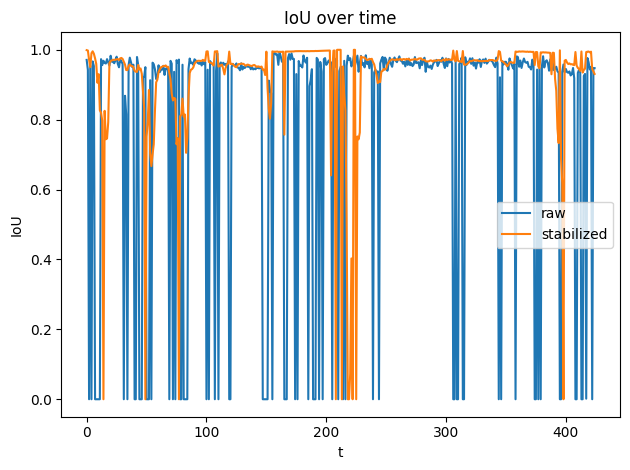

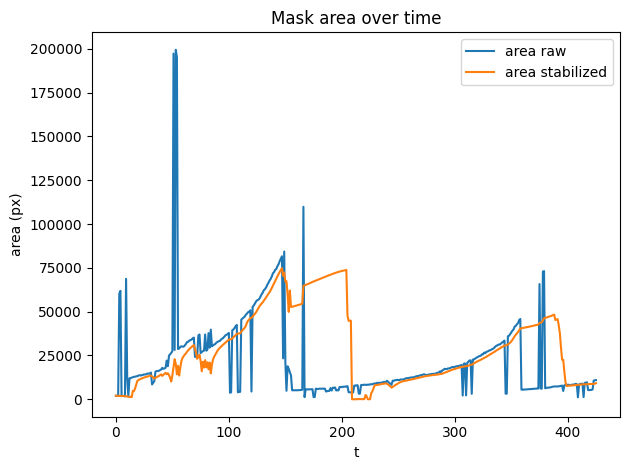

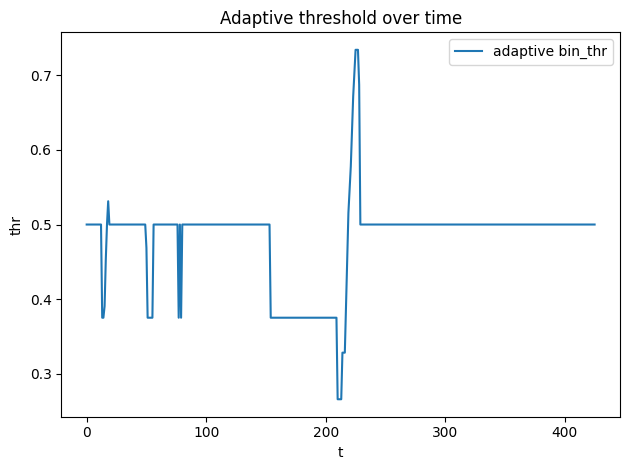

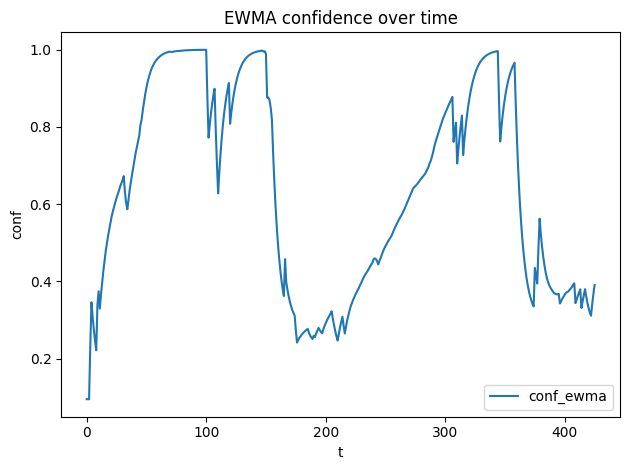

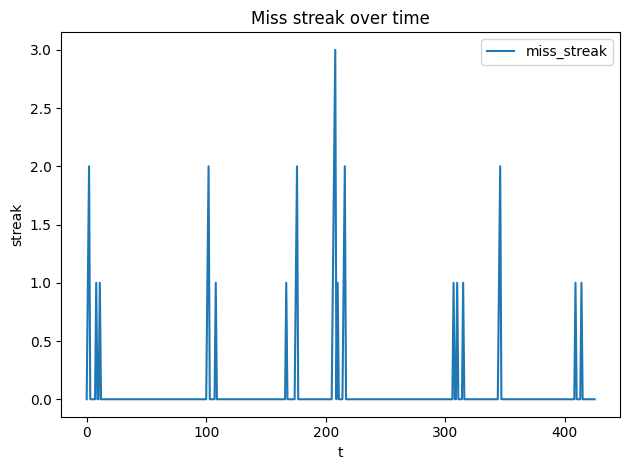

,variant,mean_iou,mean_l1,area_cv
0,raw,0.784134,0.004666,1.090802
1,stabilized,0.922808,0.000907,0.747182


{'frames_processed': 426,
 'preview_video': 'outputs_autotune_v4/best_run_full/preview_raw_vs_stabilized.mp4',
 'params': {'bin_thr': 0.5,
  'ema_beta': 0.85,
  'flow_alpha': 0.45,
  'motion_sigma': 5.0,
  'morph_kernel': 3,
  'conf_thr': 0.35},
 'raw': {'mean_iou': 0.784133959119428,
  'mean_l1': 0.0046663906213892485,
  'area_cv': 1.0908022291191055},
 'stabilized': {'mean_iou': 0.9228077760441598,
  'mean_l1': 0.0009065844551503901,
  'area_cv': 0.7471824522174885}}

In [14]:
import json

OUT_DIR = Path("outputs_autotune_v4")
summary_v4, compare_v4 = run_full_video_with_area_and_auto_vanish(
    VIDEO_PATH,
    OUT_DIR / "best_run_full",
    best_params,
    score_thresh=0.6,
    downscale=0.5,
)

display(compare_v4)
summary_v4


**Выводы:**

1. Предложенный метод временной стабилизации существенно улучшает согласованность масок во времени:
   * Mean IoU увеличился с **0.78** (raw) до **0.92** (stabilized).
2. Плавность изменения масок значительно возросла:
   * Mean L1 уменьшился более чем в **5 раз**.
3. Введённый контроль изменения площади позволил снизить коэффициент вариации площади маски:
   * area_cv уменьшился с **1.09** до **0.75**.
4. Логика авто-исчезновения эффективно устраняет артефакты «залипания» маски после выхода объекта из кадра.
5. При этом наблюдается небольшой компромисс: чрезмерное сглаживание может локально ухудшать форму маски, особенно в сложных сценах с низкой уверенностью модели.

В целом, метод демонстрирует устойчивое улучшение временной стабильности масок без изменения архитектуры или обучения модели.

---

## Итоговый вывод по работе

В данной работе была исследована задача временной стабилизации масок объектов на видеопоследовательности без переобучения модели сегментации. В качестве базовой модели была использована Mask R-CNN с предобученными весами, что обеспечило воспроизводимость эксперимента и позволило сосредоточиться на методах постобработки.

Был реализован метод сглаживания масок во времени, основанный на переносе маски по оптическому потоку, взвешенном объединении с текущим предсказанием модели и экспоненциальном усреднении. Для устранения характерных артефактов сглаживания дополнительно введены контроль резких изменений площади маски и автоматическое определение момента исчезновения объекта на основе сглаженной уверенности модели и подтверждения со стороны сырой сегментации.

Экспериментальные результаты показали, что предложенный подход существенно улучшает временную согласованность масок: среднее значение IoU между соседними кадрами увеличилось с 0.78 до 0.92, средняя L1-разница между вероятностными картами уменьшилась более чем в пять раз, а коэффициент вариации площади маски снизился с 1.09 до 0.75. При этом удалось устранить эффект «залипания» маски после выхода объекта из кадра.

В то же время было выявлено, что чрезмерное сглаживание может локально ухудшать точность формы маски в сложных сценах с низкой уверенностью модели, что подчёркивает наличие компромисса между временной стабильностью и покадровым качеством сегментации. В целом предложенное инженерное решение демонстрирует, что корректно подобранная временная постобработка позволяет значительно повысить устойчивость сегментации на видео без изменения архитектуры и обучения модели, и может служить эффективным дополнением к существующим системам видеоаналитики.
